## Calculating the metrics

In [29]:
# Paste your paths to folders with classifier logits here.
logits_path = {
    "sd_14": "YOUR_PATH",
    "ldm": "YOUR_PATH",
    "unclip": "YOUR_PATH",
    "glide": "YOUR_PATH",
    "sd_20": "YOUR_PATH",
}

In [3]:
import importlib
from src import hierarchy
from src import metrics

hierarchy = importlib.reload(hierarchy)
metrics = importlib.reload(metrics)

In [ ]:
from pathlib import Path

dataset_classes_path = Path("../wordnet_classes/imagenet.txt")
dataset_hierarchy = hierarchy.Hierarchy(dataset_classes_path.resolve())

In [5]:
synset_num_children = {}

for synset in dataset_hierarchy.get_all_synsets(remove_leaves=True):
    n_ch = len(dataset_hierarchy.get_classifiable_subtree(synset))
    synset_num_children[synset.name()] = n_ch

more_than_one_child_fn = lambda x: synset_num_children[x] > 1

In [6]:
import numpy as np


sorted_keys = np.array([k for k, v in sorted(synset_num_children.items(), key=lambda x: x[0])])
n_ch_array = np.array([v for k, v in sorted(synset_num_children.items(), key=lambda x: x[0])])
print((n_ch_array == 1).sum(), (n_ch_array != 1).sum())

388 472


In [7]:
def make_splits(path):
    for clf_name in ["convnext_base", "resnet50", "vit_b_16"]:
        logits = np.load(f"{path}/{clf_name}_logits.npz")

        assert len(logits["cat.n.01"]) % 32 == 0
        n_splits = len(logits["cat.n.01"]) // 32

        for split_id in range(n_splits):
            split = {}
            for k, v in logits.items():
                split[k] = logits[k][(split_id * 32):((split_id + 1) * 32)]
                assert split[k].shape == (32, 1000)
            np.savez(f"{path}/{clf_name}_logits_split_{split_id}.npz", **split)

In [8]:
for name in logits_path:
    make_splits(logits_path[name])

In [9]:
def calculate_metrics(path):
    results = {}

    in_prob_metric = metrics.SubtreeInProb(dataset_hierarchy, 32)
    is_metric = metrics.SubtreeIS(dataset_hierarchy, 32)
    
    for clf_name in ["convnext_base", "resnet50", "vit_b_16"]:
        for split_id in range(4):
            split_path = f"{path}/{clf_name}_logits_split_{split_id}.npz"

            results[f"{clf_name}_{split_id}_in"] = in_prob_metric.compute_metric(split_path)
            results[f"{clf_name}_{split_id}_is"] = is_metric.compute_metric(split_path)

    return results

In [11]:
model_results = {
    k: calculate_metrics(v) for k, v in logits_path.items()
}

In [28]:
for k, v in model_results.items():
    print(k)
    print("Classifier\t\tISP\t±std\tWIS\t±std")
    for clf_name in ["convnext_base", "resnet50", "vit_b_16"]:
        ins = []
        iss = []

        for split_id in range(4):
            ins.append(v[f"{clf_name}_{split_id}_in"]["average"])
            iss.append(v[f"{clf_name}_{split_id}_is"]["average"])
        
        ins = np.array(ins)
        iss = np.array(iss)
        
        print(
            f"{clf_name}\t\t{ins.mean():.4f}\t{ins.std():.4f}\t{ins.mean():.4f}\t{iss.std():.4f}"
        )
    print()

sd_14
Classifier		ISP	±std	WIS	±std
convnext_base		0.2729	0.0006	0.2729	0.0010
resnet50		0.3437	0.0015	0.3437	0.0023
vit_b_16		0.3257	0.0008	0.3257	0.0009

ldm
Classifier		ISP	±std	WIS	±std
convnext_base		0.1906	0.0010	0.1906	0.0010
resnet50		0.2189	0.0012	0.2189	0.0029
vit_b_16		0.2180	0.0009	0.2180	0.0022

unclip
Classifier		ISP	±std	WIS	±std
convnext_base		0.3009	0.0008	0.3009	0.0022
resnet50		0.3661	0.0005	0.3661	0.0024
vit_b_16		0.3522	0.0002	0.3522	0.0019

glide
Classifier		ISP	±std	WIS	±std
convnext_base		0.1874	0.0006	0.1874	0.0011
resnet50		0.2208	0.0007	0.2208	0.0023
vit_b_16		0.2205	0.0011	0.2205	0.0014

sd_20
Classifier		ISP	±std	WIS	±std
convnext_base		0.2545	0.0011	0.2545	0.0029
resnet50		0.3077	0.0013	0.3077	0.0039
vit_b_16		0.2967	0.0009	0.2967	0.0038



## Synset comparison

In [37]:
synset_in = {
    model_name: {k: v for k, v in metrics["convnext_base_0_in"].items() if k != "average"}
    for model_name, metrics in model_results.items()
}

In [38]:
synset_diff = [
    (synset_in["sd_14"][k] - synset_in["sd_20"][k], k)
    for k in sorted_keys
]
synset_diff.sort(reverse=True)

In [40]:
in_values = np.array([x[0] for x in synset_diff])
in_names = np.array([x[1].split('.')[0] for x in synset_diff])

In [51]:
high_values = in_values[in_values >= 0][::40]
low_values = in_values[in_values < 0][::-1][::40][::-1]

high_names = in_names[in_values >= 0][::40]
low_names = in_names[in_values < 0][::-1][::40][::-1]

print(len(high_idx), len(low_idx))

12 10


In [80]:
import matplotlib

matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
})
%config InlineBackend.figure_format = 'retina'
nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 14,
        "font.size": 14,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 14,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
}
matplotlib.rcParams.update(nice_fonts)

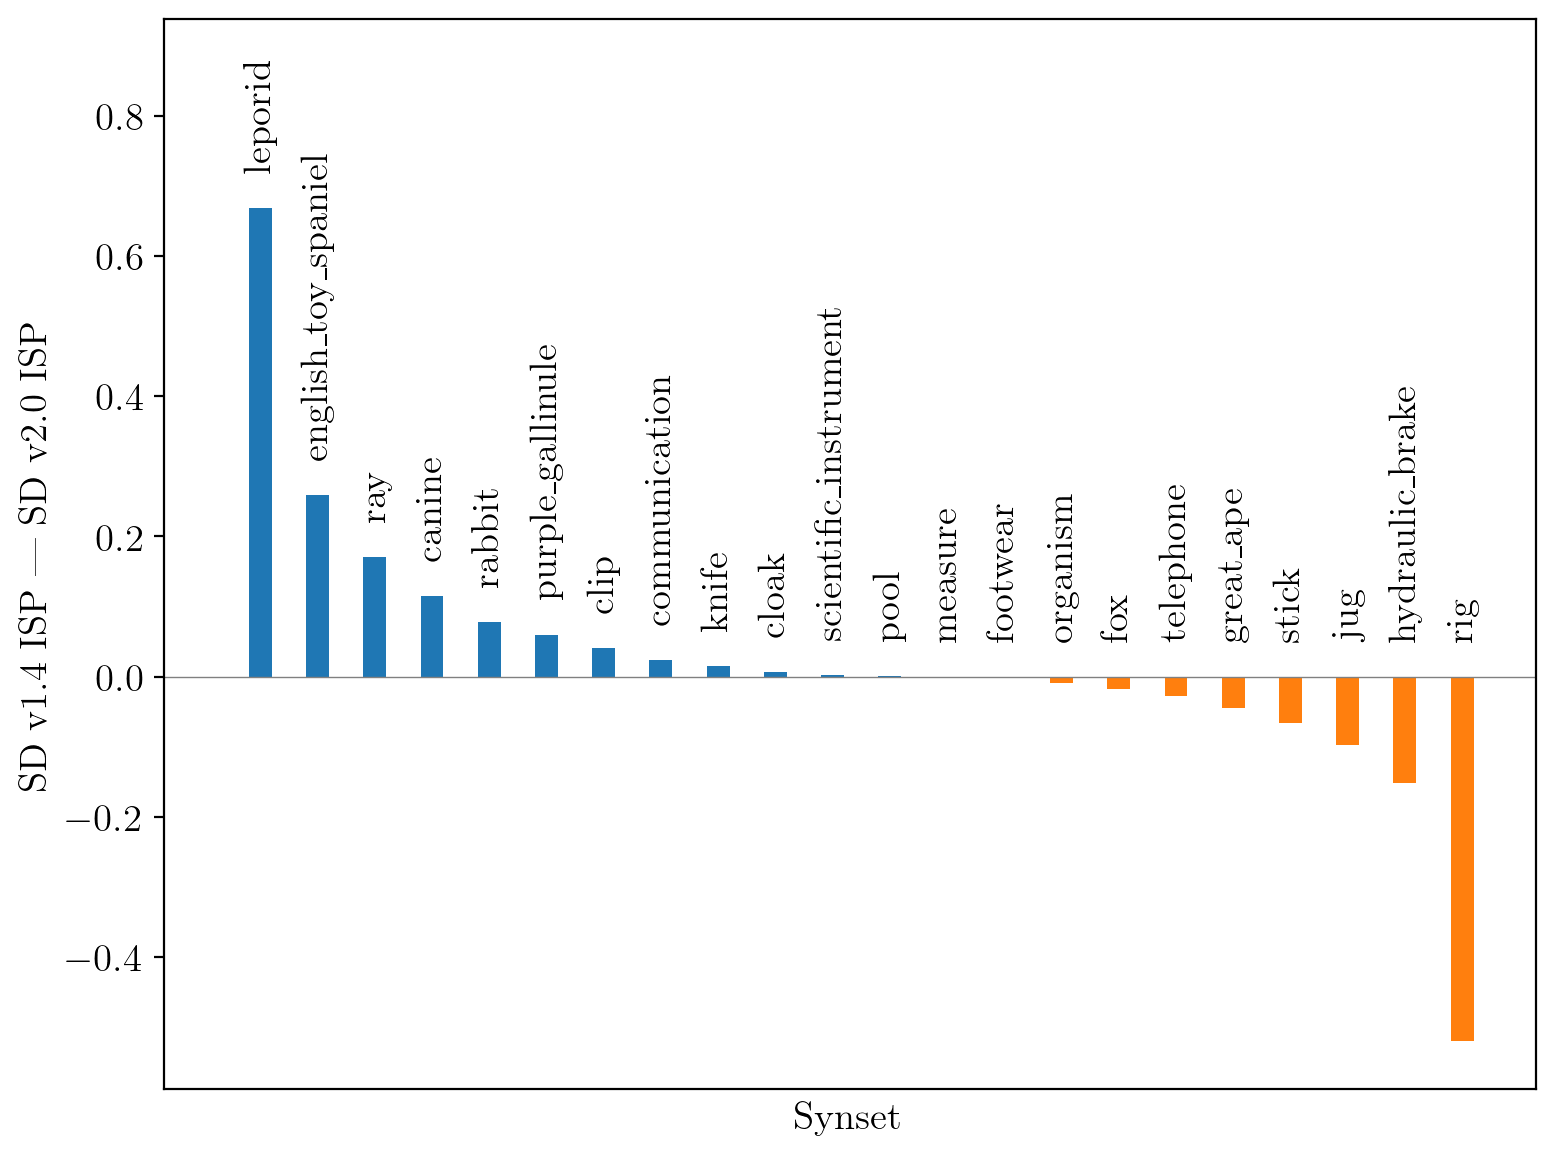

In [82]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
plt.xlabel('Synset')
plt.ylabel('SD v1.4 ISP — SD v2.0 ISP')

bar_width = 0.4

bar_high = plt.bar(
    np.arange(len(high_values)) + bar_width, high_values, bar_width, align='center')
bar_low = plt.bar(
    np.arange(len(low_values)) + bar_width + len(high_idx), low_values, bar_width, align='center')

bar_none = plt.bar(
    np.arange(2), [max(high_values) + 0.2, min(low_values)],
    bar_width, align='center', label='Fast <= 6 sec.', alpha=0.0)

# Add counts above the two bar graphs
for i, rect in enumerate(bar_high):
    height = rect.get_height()

    plt.text(
        rect.get_x() + rect.get_width() / 2,
        height + 0.05,
        f"{high_names[i]}",
        ha='center', va='bottom', rotation=90)

for i, rect in enumerate(bar_low):
    height = rect.get_height()
    x_offset = rect.get_width() * ((6 - len(low_names[i])) / 6)
    y_offset = 0.05 * ((6 - len(low_names[i])) / 6)

    plt.text(
        rect.get_x() + rect.get_width() / 2,
        0.05,
        f"{low_names[i]}",
        ha='center', va='bottom', rotation=90, horizontalalignment="left")

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tight_layout()
plt.gca().axhline(0, linestyle='-', color='gray', lw=0.5) # horizontal lines
plt.show()